In [1]:
import pandas as pd
from darts import TimeSeries
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")


# Read a pandas DataFrame
df = pd.read_csv("../data/prediction/processed_data_all_stations_weather_500101181.csv", delimiter=",")

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, "timestamp", "available_rent_bikes")

# Set timestamp as index and sort data
df = df.set_index("timestamp").sort_index()

# Display the first few rows
print(df.head())

n = int(len(series) * 0.8)
train, val = series[:n], series[-n:]

                     youbike_station_id  available_rent_bikes  \
timestamp                                                       
2025-02-13 00:00:00           500101181                    58   
2025-02-13 00:10:00           500101181                    59   
2025-02-13 00:20:00           500101181                    58   
2025-02-13 00:30:00           500101181                    56   
2025-02-13 00:40:00           500101181                    54   

                     available_return_bikes  capacity  demand  temperature  
timestamp                                                                   
2025-02-13 00:00:00                    41.0      99.0      -1    16.344444  
2025-02-13 00:10:00                    40.0      99.0       1    15.926316  
2025-02-13 00:20:00                    41.0      99.0       2    15.873684  
2025-02-13 00:30:00                    43.0      99.0       2    15.842105  
2025-02-13 00:40:00                    45.0      99.0       0    15.800000  


In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define error metric function
def evaluate_predictions(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}")
    return mae, rmse

In [3]:
# Shift the values by one step (naive approach)
df["naive_pred"] = df["available_rent_bikes"].shift(1)

# Remove first row (as it has no prediction)
df_eval = df.dropna()

# Evaluate baseline method
print("Baseline (Naive) Prediction:")
evaluate_predictions(df_eval["available_rent_bikes"], df_eval["naive_pred"])


Baseline (Naive) Prediction:
MAE: 4.450, RMSE: 8.215


(4.450279601264284, 8.214661955493622)

In [4]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (train on past data)
p, d, q = 3, 1, 2  # Tunable parameters
model = ARIMA(df["available_rent_bikes"], order=(p, d, q))
model_fit = model.fit()

# Generate rolling predictions
df["arima_pred"] = model_fit.predict()

# Drop NaNs
df_eval = df.dropna()

# Evaluate ARIMA
print("ARIMA Prediction:")
evaluate_predictions(df_eval["available_rent_bikes"], df_eval["arima_pred"])

/media/mojoee/01fc00c5-9a41-40f6-8f0e-d25ee6a8c4be/mojoee/Development/YouBike/YouBikeLive/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
/media/mojoee/01fc00c5-9a41-40f6-8f0e-d25ee6a8c4be/mojoee/Development/YouBike/YouBikeLive/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
/media/mojoee/01fc00c5-9a41-40f6-8f0e-d25ee6a8c4be/mojoee/Development/YouBike/YouBikeLive/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARIMA Prediction:
MAE: 4.440, RMSE: 7.941


(4.439684699639815, 7.941007830717515)

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
try:
    model_sarima = SARIMAX(df["available_rent_bikes"], 
                           order=(3, 1, 2), 
                           seasonal_order=(1, 1, 1, 6), 
                           enforce_stationarity=False, 
                           enforce_invertibility=False)
    model_sarima_fit = model_sarima.fit(disp=False)

    # Generate predictions
    df["sarima_pred"] = model_sarima_fit.predict()

    # Ensure predictions exist before evaluation
    if "sarima_pred" in df.columns and not df["sarima_pred"].isnull().all():
        evaluate_predictions(df_eval["available_rent_bikes"], df_eval["sarima_pred"], "SARIMA")
    else:
        print("Error: SARIMA predictions exist but contain NaNs.")

except Exception as e:
    print(f"SARIMA Model Failed: {e}")


/media/mojoee/01fc00c5-9a41-40f6-8f0e-d25ee6a8c4be/mojoee/Development/YouBike/YouBikeLive/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
/media/mojoee/01fc00c5-9a41-40f6-8f0e-d25ee6a8c4be/mojoee/Development/YouBike/YouBikeLive/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
/media/mojoee/01fc00c5-9a41-40f6-8f0e-d25ee6a8c4be/mojoee/Development/YouBike/YouBikeLive/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA Model Failed: 'sarima_pred'


In [6]:
from prophet import Prophet

# Prepare data for Prophet
df_prophet = df.reset_index()[["timestamp", "available_rent_bikes"]].rename(columns={"timestamp": "ds", "available_rent_bikes": "y"})

# Train Prophet model
prophet = Prophet(daily_seasonality=True)
prophet.fit(df_prophet)

# Predict the next values
future = prophet.make_future_dataframe(periods=len(df), freq="10min")
forecast = prophet.predict(future)

# Merge Prophet predictions back into dataframe
df["prophet_pred"] = forecast.set_index("ds")["yhat"]

# Drop NaNs
df_eval = df.dropna()

# Evaluate Prophet
print("Prophet Prediction:")
evaluate_predictions(df_eval["available_rent_bikes"], df_eval["prophet_pred"])


18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet Prediction:
MAE: 19.412, RMSE: 23.720


(19.41221440747875, 23.72042902808349)

In [7]:
from xgboost import XGBRegressor

# Prepare lag features
df["lag_1"] = df["available_rent_bikes"].shift(1)
df["lag_2"] = df["available_rent_bikes"].shift(2)

# Drop NaNs after shifting
df_xgb = df.dropna()

# Split into train/test
X_train, X_test = df_xgb[["lag_1", "lag_2"]][:-24], df_xgb[["lag_1", "lag_2"]][-24:]
y_train, y_test = df_xgb["available_rent_bikes"][:-24], df_xgb["available_rent_bikes"][-24:]

# Train XGBoost model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Make predictions
df["xgb_pred"] = xgb.predict(X_test)

# Evaluate XGBoost
evaluate_predictions(y_test, df["xgb_pred"][-24:], "XGBoost")


ValueError: Length of values (24) does not match length of index (4114)

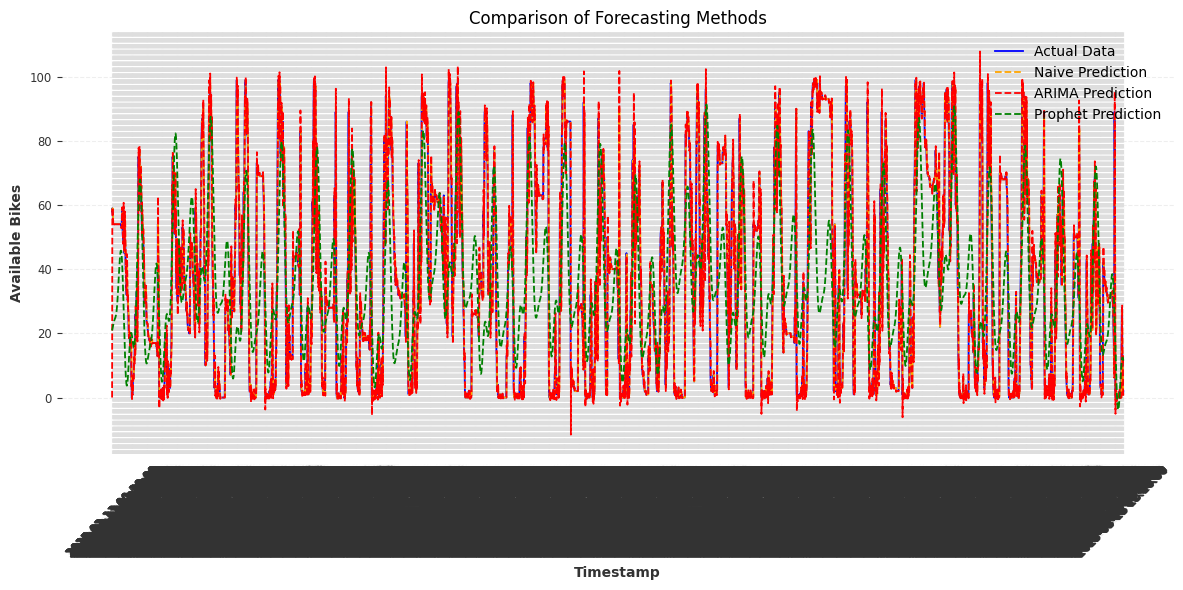

In [ ]:
import matplotlib.pyplot as plt

# Select a specific day
date_of_interest = "2025-02-20"
df_day = df[df.index.date == pd.to_datetime(date_of_interest).date()]

# Plot actual vs. predictions
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_day.index, df_day["available_rent_bikes"], label="Actual Data", color="blue")

# Plot predictions
plt.plot(df_day.index, df_day["naive_pred"], label="Naive Prediction", linestyle="--", color="orange")
plt.plot(df_day.index, df_day["arima_pred"], label="ARIMA", linestyle="--", color="red")
plt.plot(df_day.index, df_day["sarima_pred"], label="SARIMA", linestyle="--", color="purple")
plt.plot(df_day.index, df_day["prophet_pred"], label="Prophet", linestyle="--", color="green")
plt.plot(df_day.index[-24:], df_day["xgb_pred"][-24:], label="XGBoost", linestyle="--", color="brown")

# Customize the plot
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Available Bikes")
plt.title(f"Comparison of Forecasting Methods for {date_of_interest}")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Normalize the data
scaler = MinMaxScaler()
df["scaled_bikes"] = scaler.fit_transform(df[["available_rent_bikes"]])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define sequence length (how many past timesteps to consider)
seq_length = 12  # Using last 12 timesteps (2 hours) to predict next step

# Create LSTM input data
sequences, targets = create_sequences(df["scaled_bikes"].values, seq_length)

# Split into training and test sets
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

# Convert to PyTorch tensors
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: torch.Size([3281, 12]), Test set: torch.Size([821, 12])


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Output last timestep's prediction

# Model Parameters
input_dim = 1
hidden_dim = 50  # Number of LSTM neurons
num_layers = 2
output_dim = 1

# Initialize Model
lstm_model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)

# Define Loss & Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)


In [ ]:
# Train LSTM Model
num_epochs = 20  # Increase for better results

for epoch in range(num_epochs):
    lstm_model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        X_batch = X_batch.unsqueeze(-1)  # Add feature dimension
        y_batch = y_batch.unsqueeze(-1)  # Make sure shape matches
        
        y_pred = lstm_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.5f}")

print("LSTM Training Complete!")


/media/mojoee/01fc00c5-9a41-40f6-8f0e-d25ee6a8c4be/mojoee/Development/YouBike/YouBikeLive/venv/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/20, Loss: 0.06612
Epoch 2/20, Loss: 0.01928
Epoch 3/20, Loss: 0.01417
Epoch 4/20, Loss: 0.01044
Epoch 5/20, Loss: 0.00833
Epoch 6/20, Loss: 0.00717
Epoch 7/20, Loss: 0.00680
Epoch 8/20, Loss: 0.00693
Epoch 9/20, Loss: 0.00653
Epoch 10/20, Loss: 0.00686
Epoch 11/20, Loss: 0.00671
Epoch 12/20, Loss: 0.00652
Epoch 13/20, Loss: 0.00667
Epoch 14/20, Loss: 0.00642
Epoch 15/20, Loss: 0.00647
Epoch 16/20, Loss: 0.00691
Epoch 17/20, Loss: 0.00644
Epoch 18/20, Loss: 0.00640
Epoch 19/20, Loss: 0.00634
Epoch 20/20, Loss: 0.00649
LSTM Training Complete!


In [ ]:
# Switch to evaluation mode
lstm_model.eval()

# Predict on test data
predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.unsqueeze(-1)  # Add feature dimension
        y_pred = lstm_model(X_batch)
        predictions.extend(y_pred.numpy())

# Convert predictions back to original scale
df["lstm_pred"] = np.nan  # Ensure column exists
predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Ensure indices match when inserting into DataFrame
df.iloc[-len(predictions_rescaled):, df.columns.get_loc("lstm_pred")] = predictions_rescaled

# Ensure predictions exist before evaluation
if "lstm_pred" in df.columns:
    evaluate_predictions(df_eval["available_rent_bikes"], df_eval["lstm_pred"], "LSTM")
else:
    print("Error: LSTM predictions not found.")


KeyError: 'lstm_pred'

In [ ]:
import matplotlib.pyplot as plt

# Select a specific day
date_of_interest = "2025-02-20"
df_day = df[df.index.date == pd.to_datetime(date_of_interest).date()]

# Plot actual vs. predictions
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_day.index, df_day["available_rent_bikes"], label="Actual Data", color="blue")

# Plot all predictions
plt.plot(df_day.index, df_day["naive_pred"], label="Naive", linestyle="--", color="orange")
plt.plot(df_day.index, df_day["arima_pred"], label="ARIMA", linestyle="--", color="red")
plt.plot(df_day.index, df_day["sarima_pred"], label="SARIMA", linestyle="--", color="purple")
plt.plot(df_day.index, df_day["prophet_pred"], label="Prophet", linestyle="--", color="green")
plt.plot(df_day.index[-len(predictions):], df_day["lstm_pred"][-len(predictions):], label="LSTM", linestyle="--", color="black")

# Customize the plot
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Available Bikes")
plt.title(f"Forecasting Methods Comparison for {date_of_interest}")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()


AttributeError: 'Index' object has no attribute 'date'